# F1 Championship Tracker

## Introduction
The current set of regulations in F1 has made for an entertaining couple of years and I decided to try summarise it with visuals. Currently the most talked about team is McLaren who finished 2022 in 6th place in the Constructors standing but are currently in 2nd place and look likely to overtake Red Bull to take the top spot. Hopefully this will help contextualise just how much they've improved. To do this I'll be getting data from the offical F1 website (www.formula1.com) and making use of the libraries below:
- requests: Used to retrieve HTML content from the various webpages.
- BeautifulSoup: Used to extract specific elements within the HTML such as tables and rows.
- pandas: Used for data manipulation and analysis. Specifically creating dataframes, merging information from multiple tables and grouping data to calculate statistics such as the mean race position and total wins.
- urllib.parse: Used to parse the various URLs and decode specific elements.
- Seaborn: Used to create visualisations once the data has been transformed.
- matplotlib: Used to adjust the size of graphs produced using Seaborn.


In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from urllib.parse import urlparse, unquote
import seaborn as sns
import matplotlib.pyplot as plt

## Creating functions to manipulate existing data

The one piece of information that isn't available on the official website is data on the engine suppliers. After looking at 'https://www.formula1.com/en/results/2024/team' I saw that the engine supplier is included in the team name so can be extracted once the table has been scraped. In the name of avoiding repetition I created a function to split the data within the 'Team' column. After further inspection I noticed some mismatch in formatting for one driver, 'Zhou Guanyu'. Within the drivers championship on 'https://www.formula1.com/en/results/2024/drivers' his name is 'Zhou Guanyu' but in the URL leading to his personal page it is 'guanyu zhou'. Since it was going to be a persistent problem it was easier to create a function to switch the first and last name around, this way if another driver appears with the same problem I can make use of this function again.

In [2]:
drivers = [
    {'name': 'alexander_albon', 'id': 'ALEALB01'},
    {'name': 'fernando_alonso', 'id': 'FERALO01'},
    {'name': 'valtteri_bottas', 'id': 'VALBOT01'},
    {'name': 'nyck_de_vries', 'id': 'NYCDEV01'},
    {'name': 'pierre_gasly', 'id': 'PIEGAS01'},
    {'name': 'lewis_hamilton', 'id': 'LEWHAM01'},
    {'name': 'nico_hulkenberg', 'id': 'NICHUL01'},
    {'name': 'nicholas_latifi', 'id': 'NICLAF01'},
    {'name': 'charles_leclerc', 'id': 'CHALEC01'},
    {'name': 'kevin_magnussen', 'id': 'KEVMAG01'},
    {'name': 'lando_norris', 'id': 'LANNOR01'},
    {'name': 'esteban_ocon', 'id': 'ESTOCO01'},
    {'name': 'sergio_perez', 'id': 'SERPER01'},
    {'name': 'daniel_ricciardo', 'id': 'DANRIC01'},
    {'name': 'carlos_sainz', 'id': 'CARSAI01'},
    {'name': 'mick_schumacher', 'id': 'MICSCH02'},
    {'name': 'lance_stroll', 'id': 'LANSTR01'},
    {'name': 'yuki_tsunoda', 'id': 'YUKTSU01'},
    {'name': 'max_verstappen', 'id': 'MAXVER01'},
    {'name': 'sebastian_vettel', 'id': 'SEBVET01'},
    {'name': 'guanyu_zhou', 'id': 'GUAZHO01'},
    {'name': 'george_russell', 'id': 'GEORUS01'},
    # 2023 drivers
    {'name': 'oscar_piastri', 'id': 'OSCPIA01'},
    {'name': 'logan_sargeant', 'id': 'LOGSAR01'},
    {'name': 'liam_lawson', 'id': 'LIALAW01'},
    # 2024 drivers
    {'name': 'oliver bearman', 'id': 'OLIBEA01'},
    {'name': 'franco-colapinto', 'id': 'FRACOL01'}
]

# Function to correctly format specific names
def swap_name(driver_name):
    name_swaps = {
        'guanyu zhou': 'zhou guanyu'
    }
    
    driver_name_lower = driver_name.lower()                 # Tranforms the drivers name to lower case
    
    if driver_name_lower in name_swaps:                     # If a drivers name is in name_swap then it swaps the name otherwise it returns the drivers name
        return name_swaps[driver_name_lower]
    else:
        return driver_name

def get_engine_supplier(car_name):                          # Function to extract the engine supplier from the team name
    parts = car_name.split()

    return parts[-1]

def remove_engine_supplier(car_name):                       # Function to remove the engine supplier from the team name
    parts =  car_name.split()
    result = ' '.join(parts[:-1])
    
    return result

def remove_engine_supplier_if_needed(df):                   # Function to see if the above function needs to be applied
    car_list = []
    for i in df['Car']:                                     # If there's a space in the team name then it'll apply that function if there isn't then it'll append the car name
        if ' ' not in i:
            car_list.append(i)
        elif i == 'Red Bull Racing Honda RBPT':
            car_list.append('Red Bull Racing')
        elif i == 'AlphaTauri Honda RBPT':
            car_list.append('AlphaTauri')
        else:
            car = remove_engine_supplier(i)
            car_list.append(car)
    
    df['Car'] = car_list
    return df

## Creating a function to extract data from the Drivers Championship for any given year

This was probably the easier function to create as after inspecting the URL everything remained the same apart from the year. Since there was only one table on that webpage it was quite straightforward  to eextract the various elements. Within this function I also used the get_engine_supplier function to extract the engine supplier from each team name. I also created a new column to represent whether a driver finished in the top 10 of the drivers championship.

In [3]:
def scrape_driver_standings(year):
    url = f"https://www.formula1.com/en/results/{year}/drivers"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html")
    
    header = soup.find_all('th')                                                                              # Finds all the table headers within that webpage
    table_header = [title.text.strip() for title in header]                                                   # Strips the result down to just the table header

    df = pd.DataFrame(columns=table_header)

    data = soup.find_all('td')                                                                                # Find the table data
    table_data = [value.text.strip() for value in data]

    # Reshape the data into rows
    rows = len(table_data) // len(table_header)                                                               # Determine number of rows

    table_rows = [table_data[i * len(table_header):(i + 1) * len(table_header)] for i in range(rows)]         # Create rows from table_data

    # Add the rows to the DataFrame
    for row in table_rows:
        df.loc[len(df)] = row                                                                                 # Append each row to the DataFrame

    df['Driver'] = df['Driver'].str[:-3]                                                                      # Remove driver abbreviation from Driver column
    df['Driver'] = df['Driver'].str.replace('\xa0', ' ')
    df['Driver'] = df['Driver'].str.lower().str.strip().str.replace('_', ' ')

    df['Engine Supplier'] = df['Car'].apply(get_engine_supplier)                                              # Get the engine supplier from the Car column

    remove_engine_supplier_if_needed(df)                                                                      # Shorten the team name

    df['Year'] = year

    df['Pts'] = df['Pts'].astype(int)                                                                         # Converts the Points column from string to integer

    Top_10 = []

    for i in df['Pos']:                                                                                       # This is a new column to show if a driver is in the top half of the table
        if int(i) <= 10:
            Top_10.append(1)
        else:
            Top_10.append(0)

    df['Top 10'] = Top_10

    driver_table = df
    return driver_table


## Creating a function to retrieve and clean the results for every driver in any given year

This is where it gets a little complicated and the reason we have a list of drivers along with the driver ID which is taken from the URL from their page with 'https://www.formula1.com/en/results/2024/drivers/GUAZHO01/guanyu-zhou' being an example. The process is pretty much the same as the previous function except we only wanted to return the last 2 columns from the available columns from this table - race position and total points.

In [4]:
def scrape_race_results(year,drivers):
    base_url = f"https://www.formula1.com/en/results/{year}/drivers/{{}}/{{}}"

    rows_list = []

    for driver in drivers:
        driver_name = driver['name']
        driver_id = driver['id']
        
        url = base_url.format(driver_id, driver_name)                                                           # Create the URL for the current driver
    
        page = requests.get(url)                                                                                # Send the request to the URL
        soup = BeautifulSoup(page.text, "html")
        
        rows = soup.find_all('tr')                                                                              # Find all rows in the table
        
        for row in rows[1:]:                                                                                    # Get race position and points for each row skipping the table header
            td = row.find_all('td')

            race_date = td[1].text.strip()                                                                      # Only extracting the data needed
            circuit = td[0].text.strip()
            car = td[2].text.strip()
            race_position = td[-2].text.strip()
            points = td[-1].text.strip()
            
            row_data = {'Driver': driver_name.replace('_', ' ').title(),                                        # Preparing the data to be added to the rows_list
                        'Circuit': circuit,
                        'Car': car,
                        'Date': race_date,
                        'Race Position': race_position, 
                        'PTS': int(points)}
            
            rows_list.append(row_data)

    results_df = pd.DataFrame(rows_list, columns=['Driver', 'Circuit', 'Car', 'Date', 'Race Position', 'PTS'])  # Convert the list of dictionaries to a DataFrame

    results_df['Driver'] = results_df['Driver'].str.replace('\xa0', ' ')
    results_df['Driver'] = results_df['Driver'].str.lower().str.strip().str.replace('_', ' ')
    results_df['Driver'] = results_df['Driver'].apply(swap_name)

    results_df['Date'] = pd.to_datetime(results_df['Date'], format = '%d %b %Y')                                # Converting the date column from string to date

    return results_df

def aggregate_team_results(race_results_df):                                                                    # Creating a function which drops the driver and race position column so it can be shown on a team level
    df = race_results_df.drop(columns = ['Driver', 'Race Position'])
    df = df.groupby(['Circuit', 'Date','Car']).agg(
        Total_Points = ('PTS','sum')
    ).reset_index()

    remove_engine_supplier_if_needed(df)

    return df


## Creating a function which calculates the driver statistics

When inspecting the table for any given driver the first thing that stood out to me was that the 'Race Position' column was formatted as string because there were values such as DNF (Did Not Finish) and DNS (Did Not Start) within that data. That information was useful so in addition to creating a brand new column just for the numerical race position, I also added new columns which would show why any given driver did not finish a race if they didn't.

I also thought it'd be nice to see some graphics on info such as race wins, podiums and top 5 finishes in all the races so I added additional columns for that. Additionally I calculated the mean race position for every driver every year along with the standard deviation of the race positions. This would give good insight as to the consistency of each driver throughout the year(s).

In [5]:
def calculate_statistics(table_name):

    Race_Position = []                                                                                 # Creating new columns for DNF, DNS, Race Position, Wins, Podiums and Top 5 finishes
    DNF = []
    DNS = []
    DSQ = []
    Wins = []
    Podiums = []
    Top_5 = []

    for i in table_name['Race Position']:                                                              # Loops through 'Race Position' to check where a driver finished. If they didn't finish that would be noted in respective column
        if i == 'DNF':
            DNF.append(1)
            Race_Position.append(None)
            DNS.append(0)
            DSQ.append(0)
        elif i == 'DNS':
            DNS.append(1)
            DNF.append(0)
            Race_Position.append(None)
            DSQ.append(0)
        elif i == 'DSQ':
            DSQ.append(1)
            DNF.append(0)
            DNS.append(0)
            Race_Position.append(None)
        else:
            Race_Position.append(int(i))                                                               # If a driver did finish the race then that position would be added to a new column
            DNF.append(0)
            DNS.append(0)
            DSQ.append(0)

    table_name['New Race Position'] = Race_Position

    for i in table_name['New Race Position']:                                                          # Using the new race position column to segment where drivers finished
        if i == None:
            Wins.append(None)
            Podiums.append(None)
            Top_5.append(None)
        elif i == 1:
            Wins.append(1)
            Podiums.append(1)
            Top_5.append(1)
        elif 1 < i <= 3:
            Wins.append(0)
            Podiums.append(1)
            Top_5.append(1)
        elif 3 < i <= 5:
            Wins.append(0)
            Podiums.append(0)
            Top_5.append(1)
        else:
            Wins.append(0)
            Podiums.append(0)
            Top_5.append(0)

    table_name['DNF'] = DNF
    table_name['DNS'] = DNS
    table_name['Wins'] = Wins
    table_name['Podiums'] = Podiums
    table_name['Top_5'] = Top_5
    table_name['DSQ'] = DSQ

    # Creating new variables which will be added to the drivers df
    Race_Position_Mean = table_name.groupby('Driver')['New Race Position'].mean().reset_index().rename(columns = {'New Race Position': 'Race Position Mean'})
    Race_Position_Standard_Deviation = table_name.groupby('Driver')['New Race Position'].std().reset_index().rename(columns = {'New Race Position': 'Race Position Standard Deviation'})
    Total_DNFs = table_name.groupby('Driver')['DNF'].sum().reset_index().rename(columns = {'DNF': 'Total DNFs'})
    Total_DNSs = table_name.groupby('Driver')['DNS'].sum().reset_index().rename(columns = {'DNS': 'Total DNSs'})
    Total_DSQs = table_name.groupby('Driver')['DSQ'].sum().reset_index().rename(columns = {'DSQ': 'Total DSQs'})
    Total_Wins = table_name.groupby('Driver')['Wins'].sum().reset_index().rename(columns = {'Wins': 'Total Wins'})
    Total_Podiums = table_name.groupby('Driver')['Podiums'].sum().reset_index().rename(columns = {'Podiums': 'Total Podiums'})
    Total_Top5s = table_name.groupby('Driver')['Top_5'].sum().reset_index().rename(columns = {'Top 5': 'Total Top5s'})
    
    # Merge all statistics into one df
    stats_df = Race_Position_Mean.merge(Race_Position_Standard_Deviation, on = 'Driver')\
                                .merge(Total_DNFs, on = 'Driver')\
                                .merge(Total_DNSs, on = 'Driver')\
                                .merge(Total_DSQs, on = 'Driver')\
                                .merge(Total_Wins, on = 'Driver')\
                                .merge(Total_Podiums, on = 'Driver')\
                                .merge(Total_Top5s, on = 'Driver')
    return stats_df

## Final function to format and combine all the data into one table

This is where I created one final function which would use the other three functions and combine the various outputs into one structered format and export it as an Excel file. Within this function I have added the 'years' variable where you can amend the years which you'd like to inspect.

In [6]:
def combine_tables():
    years = [2022, 2023, 2024]
    
    # Initialise empty DataFrames to store the combined data
    combined_team_df = pd.DataFrame()  
    combined_driver_df = pd.DataFrame()
    aggregated_team_results = pd.DataFrame()
    
    # Loop over each year to scrape and process data
    for year in years:
        driver_standings = scrape_driver_standings(year)
        race_results = scrape_race_results(year, drivers)
        
        driver_stats = calculate_statistics(race_results)

        # Merge the scraped driver standings with calculated statistics
        year_df = driver_standings.merge(driver_stats, on='Driver', how='left')
        
        # Concatenate the current year's driver standings to the combined DataFrame
        combined_driver_df = pd.concat([combined_driver_df, year_df])

        # Aggregate the race results to the team level for the current year
        team_race_results = aggregate_team_results(race_results)

        team_race_results['Year'] = year
        
        # Sort the results by team and date so that cumulative points can be calculated
        team_race_results = team_race_results.sort_values(by=['Car', 'Date'], ascending=True)
        
        # Calculate cumulative points over the year (running total of points per team)
        team_race_results['Cumulative_Points_Over_Year'] = team_race_results.groupby(['Car', 'Year'])['Total_Points'].cumsum()
        
        # Concatenate the current year's team race results to the aggregated results DataFrame
        aggregated_team_results = pd.concat([aggregated_team_results, team_race_results]).reset_index(drop=True)

    # After looping through the years, calculate the cumulative points over the regulation period and the rolling average points
    aggregated_team_results['Cumulative_Points_Over_Reg'] = aggregated_team_results.groupby('Car')['Total_Points'].cumsum()
    aggregated_team_results['Rolling_Average_Points'] = round(
        aggregated_team_results.groupby('Car')['Total_Points'].transform(lambda x: x.expanding().mean()), 2)

    # Create the team standings DataFrame from the combined driver DataFrame
    team_standings = combined_driver_df.drop(columns=['Pos', 'Driver', 'Nationality', 'Top 10', 'Race Position Mean', 
                                                      'Race Position Standard Deviation', 'Total DNFs', 'Total DNSs', 'Total DSQs'])
    
    # Group by team, year, and engine supplier, and calculate total points, wins, podiums, and top 5 finishes
    team_standings = team_standings.groupby(['Car', 'Year', 'Engine Supplier']).agg(
        Total_Points=('Pts', 'sum'),
        Total_Wins=('Total Wins', 'sum'),
        Total_Podiums=('Total Podiums', 'sum'),
        Total_Top_5s=('Top_5', 'sum')
    ).reset_index()

    # Calculate the maximum points in each year for comparison
    team_standings['Max_Pts'] = team_standings.groupby('Year')['Total_Points'].transform('max')
    
    # Calculate the distance from the first-place team (points difference from the leader)
    team_standings['Distance From First'] = team_standings['Max_Pts'] - team_standings['Total_Points']
    
    # Drop the Max_Pts column since it's no longer needed
    team_standings.drop(columns=['Max_Pts'], inplace=True)

    # Concatenate the current team standings with the combined team DataFrame
    combined_team_df = pd.concat([combined_team_df, team_standings]).reset_index(drop=True)
    combined_team_df = combined_team_df.sort_values(['Year', 'Total_Points'], ascending = [True, False])

    # Write all three tables (driver standings, team standings, race results) to an Excel file
    with pd.ExcelWriter('WDC_2022_2024_with_Team.xlsx') as writer:
        combined_driver_df.to_excel(writer, sheet_name='Driver Standings', index=False)
        combined_team_df.to_excel(writer, sheet_name='Team Standings', index=False)
        aggregated_team_results.to_excel(writer, sheet_name='Race Results', index=False)

    return combined_driver_df, combined_team_df, aggregated_team_results

wdc_2022_2024, wcc_2022_2024, race_results = combine_tables()

## Visualising the data

This is where I create visualisations to summarise each drivers performance from 2022 till now.

### Creating a bar graph to show the total points accumulated for each team over the current set of regulations

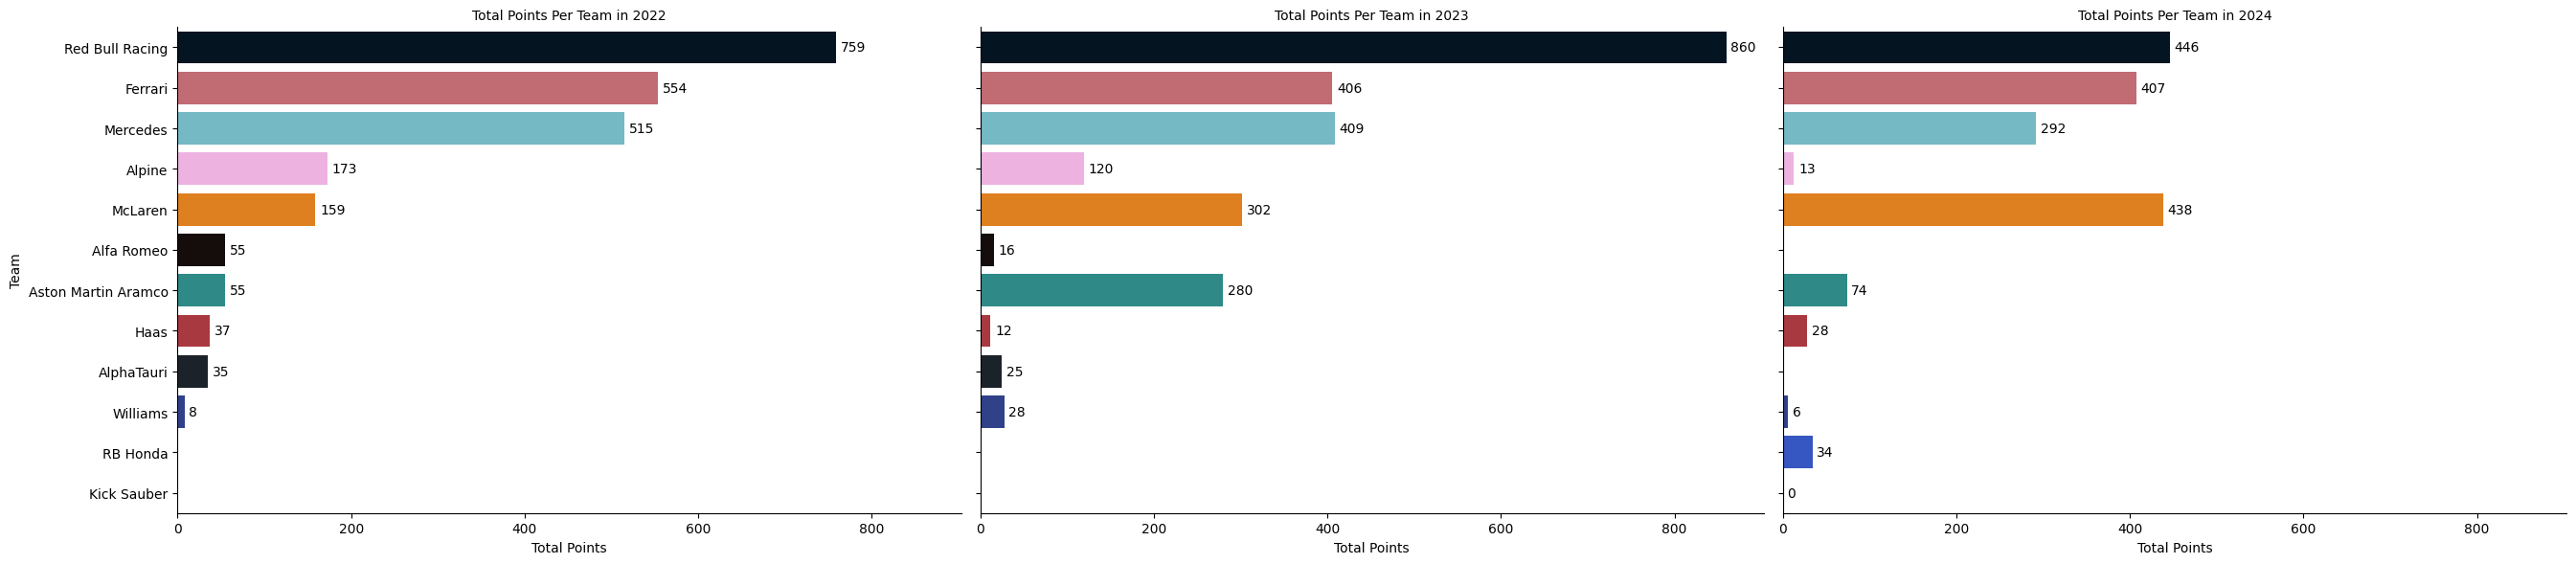

In [7]:
colour_palette = {
    'McLaren': '#FF8000',
    'Ferrari': '#cf5d67',
    'Mercedes': '#68c3d1',
    'Red Bull Racing': '#001526',
    'Aston Martin Aramco': '#1f9896',
    'Alpine': '#f7a8e5',
    'Williams': '#213799',
    'Haas': '#bc2630',
    'Alfa Romeo': '#160b0b',
    'AlphaTauri': '#1a222c',
    'RB Honda': '#1f4ad8',
    'Kick Sauber': '#3cde37'
}

# Set up a FacetGrid
g = sns.FacetGrid(wcc_2022_2024, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot, x = 'Total_Points', y = 'Car', hue = 'Car',data = wcc_2022_2024, order=wcc_2022_2024['Car'].unique(),legend = False, palette=colour_palette, errorbar = None)
            
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width (Pts value)
        if not np.isnan(width):  # Make sure width is a valid number
            ax.text(width + 5,  # Adjust the positioning of the text to offset from the bar
                    p.get_y() + p.get_height() / 2,  # Vertically center the label on the bar
                    f'{int(width)}',  # Format the text as an integer
                    va='center')  # Center the text vertically

# Adjust the titles and layout
g.set_titles("Total Points Per Team in {col_name}")
g.set_axis_labels("Total Points", "Team")
plt.tight_layout()
plt.show()

As you can see Red Bull have been dominating the current set of regulations but that domination seems to be coming to an end this year with both Ferrari and McLaren catching up in the constructors championship. The following graph will show by how many points the other teams have closed the gap to Red Bull.

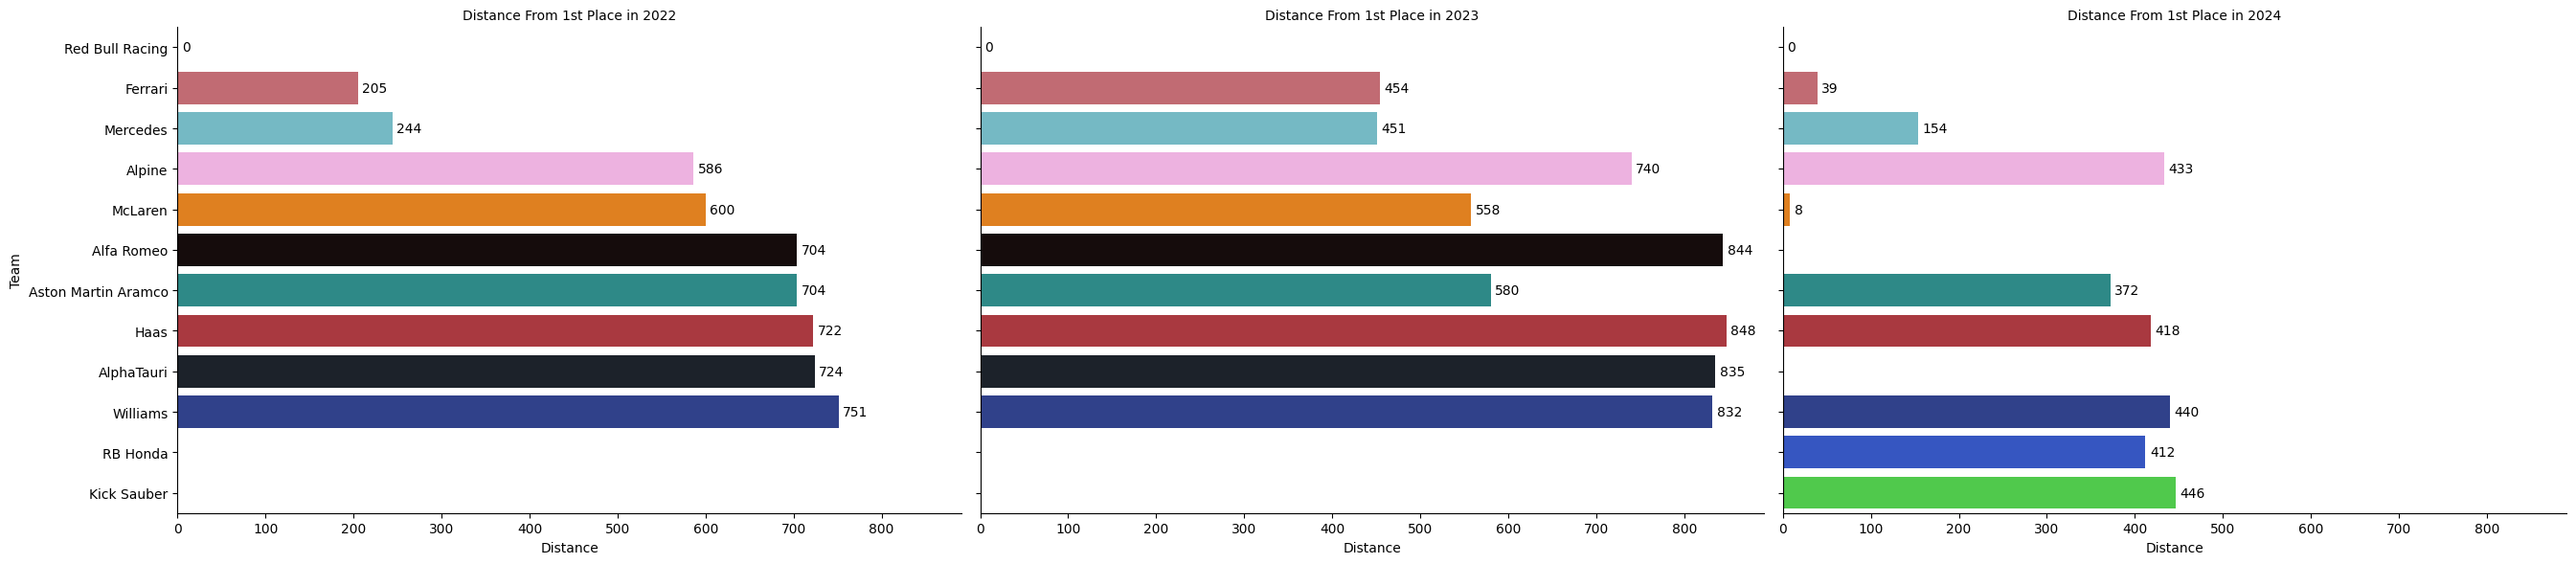

In [8]:
# Set up a FacetGrid
g = sns.FacetGrid(wcc_2022_2024, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot, data = wcc_2022_2024, x = 'Distance From First', y = 'Car', order=wcc_2022_2024['Car'].unique(), hue = 'Car', legend = False, palette = colour_palette, errorbar = None)
            
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width (Pts value)
        if not np.isnan(width):  # Make sure width is a valid number
            ax.text(width + 5,  # Adjust the positioning of the text to offset from the bar
                    p.get_y() + p.get_height() / 2,  # Vertically center the label on the bar
                    f'{int(width)}',  # Format the text as an integer
                    va='center')  # Center the text vertically
        

# Adjust the titles and layout
g.set_titles("Distance From 1st Place in {col_name}")
g.set_axis_labels("Distance", "Team")
plt.tight_layout()
plt.show()

It's interesting to see the difference between the 3 years because it's clear Red Bull ran away with it in 2023 but it was relatively close in the other years with this year shaping up to be very competitive at the top.
Now we're gonna see just how many podiums the top for teams this year have achieved over the past 3 years.

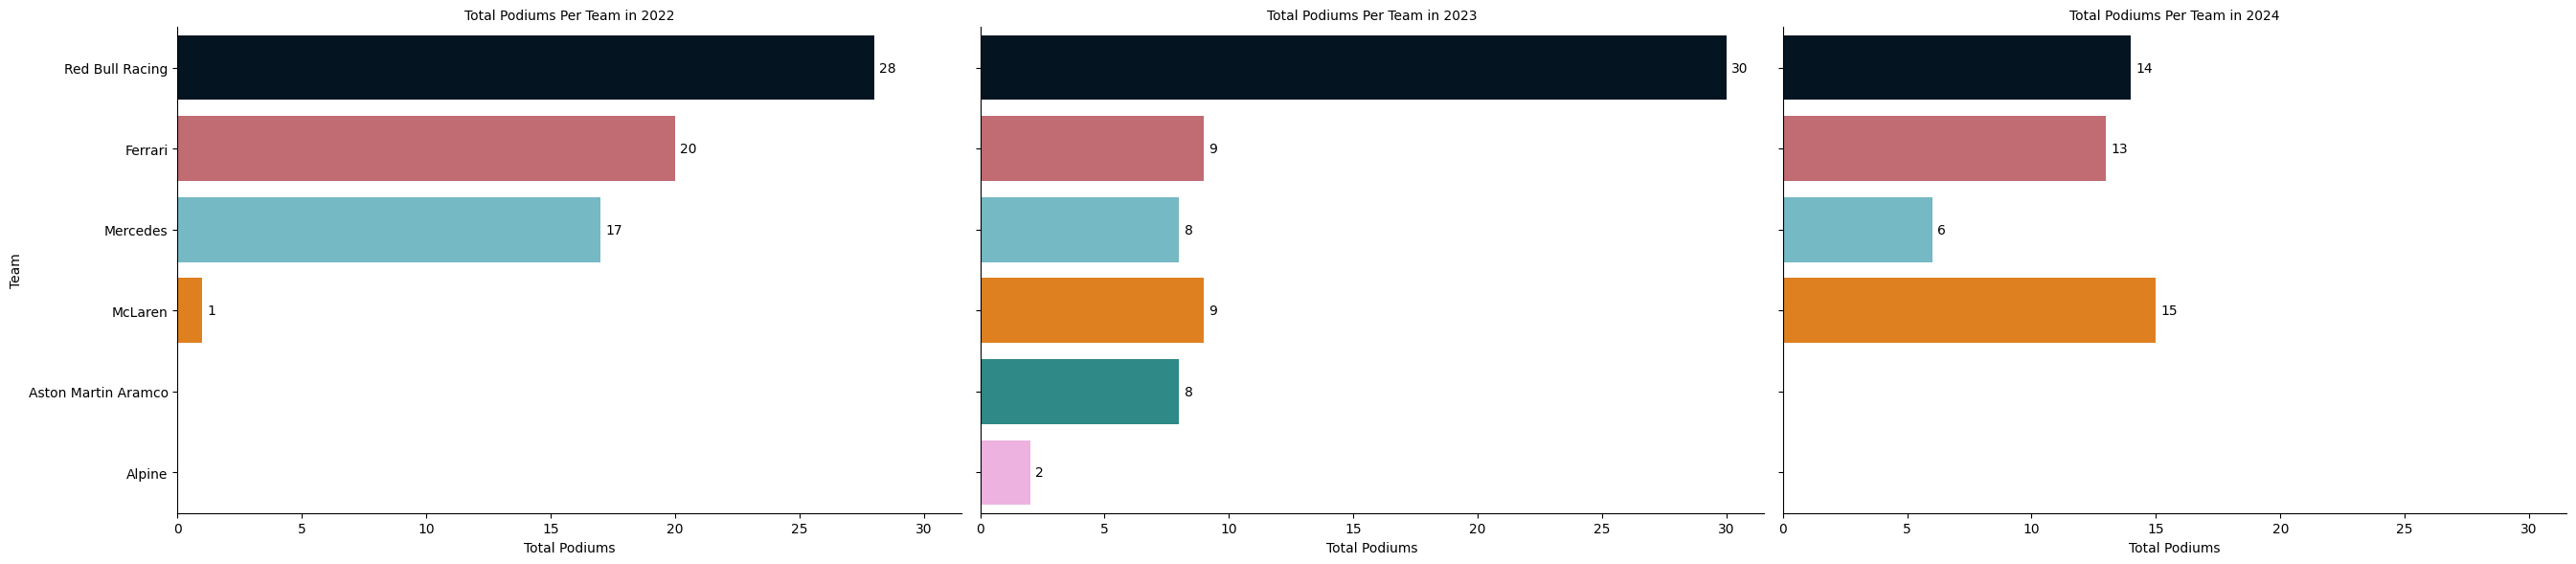

In [9]:
# Set up a FacetGrid

race_podiums_per_team = wcc_2022_2024[wcc_2022_2024['Total_Podiums'] > 0]

# Set up a FacetGrid
g = sns.FacetGrid(race_podiums_per_team, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot,data = race_podiums_per_team, x = 'Total_Podiums', y = 'Car', order=race_podiums_per_team['Car'].unique(), hue = 'Car', legend = False, palette = colour_palette, errorbar = None)

# Add labels to each bar in each facet
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width
        ax.text(width + 0.2,    # Position label slightly offset from the bar
                p.get_y() + p.get_height() / 2,  # Center label vertically on the bar
                f'{width:.0f}',   # The label text
                va='center')

# Adjust the titles and layout
g.set_titles("Total Podiums Per Team in {col_name}")
g.set_axis_labels("Total Podiums", "Team")
plt.tight_layout()
plt.show()

The next 2 graphs will illustrate how many wins each team and driver achieved over the current set of regulations. On the face of it it looks like Red Bull dominated 2023 and the other teams having caught up this year, especially in McLarens case but this may be different looking at just race winners.

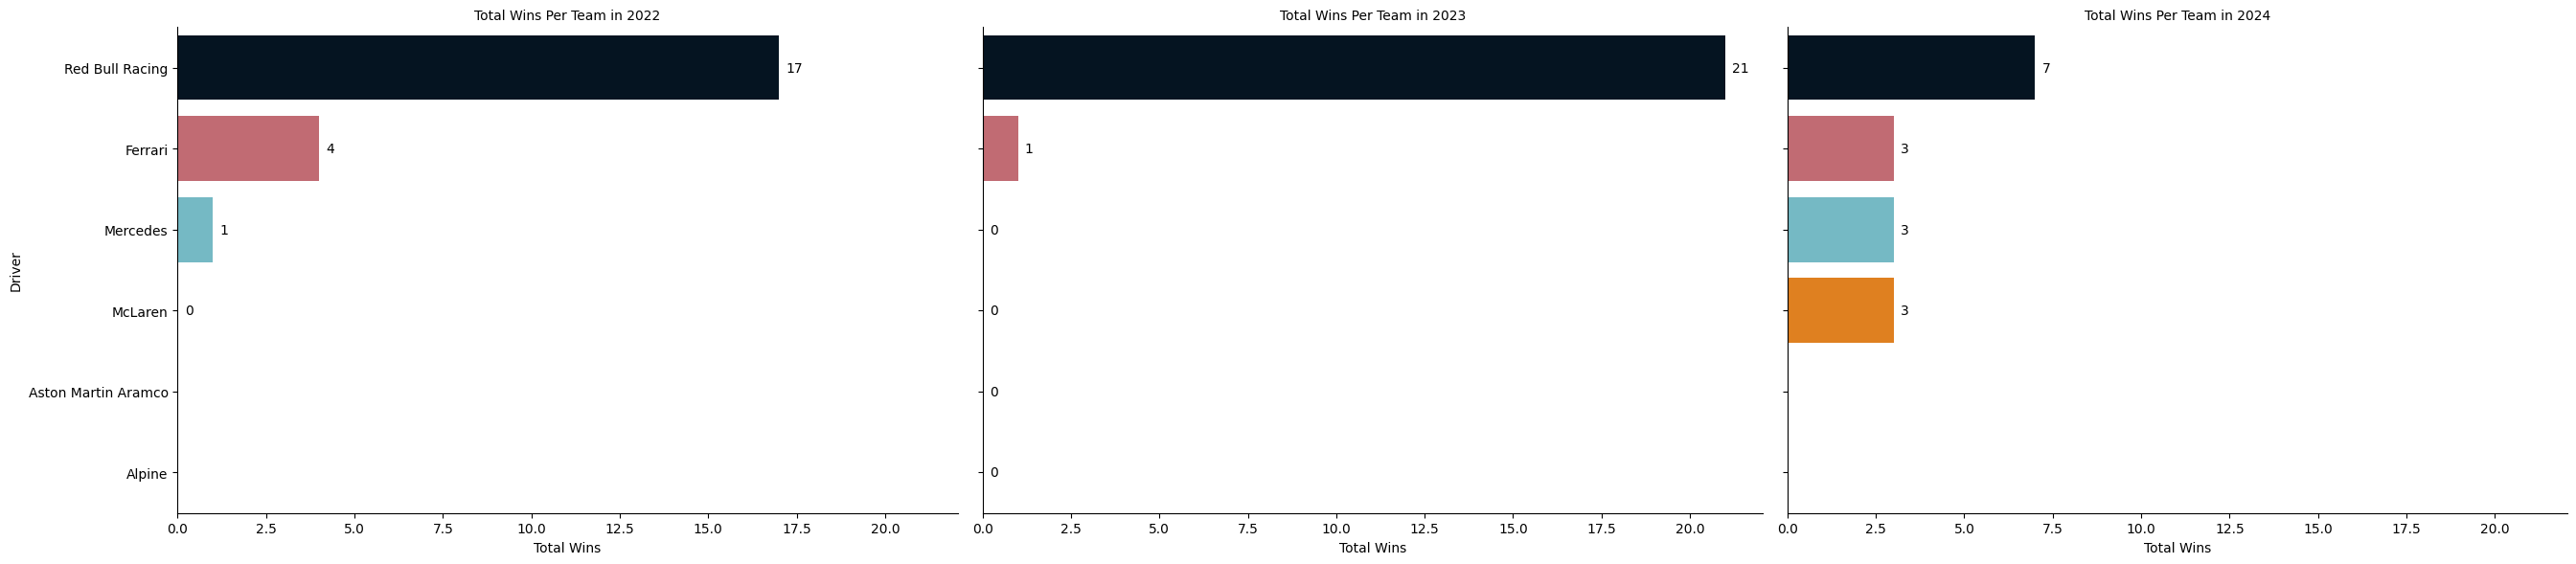

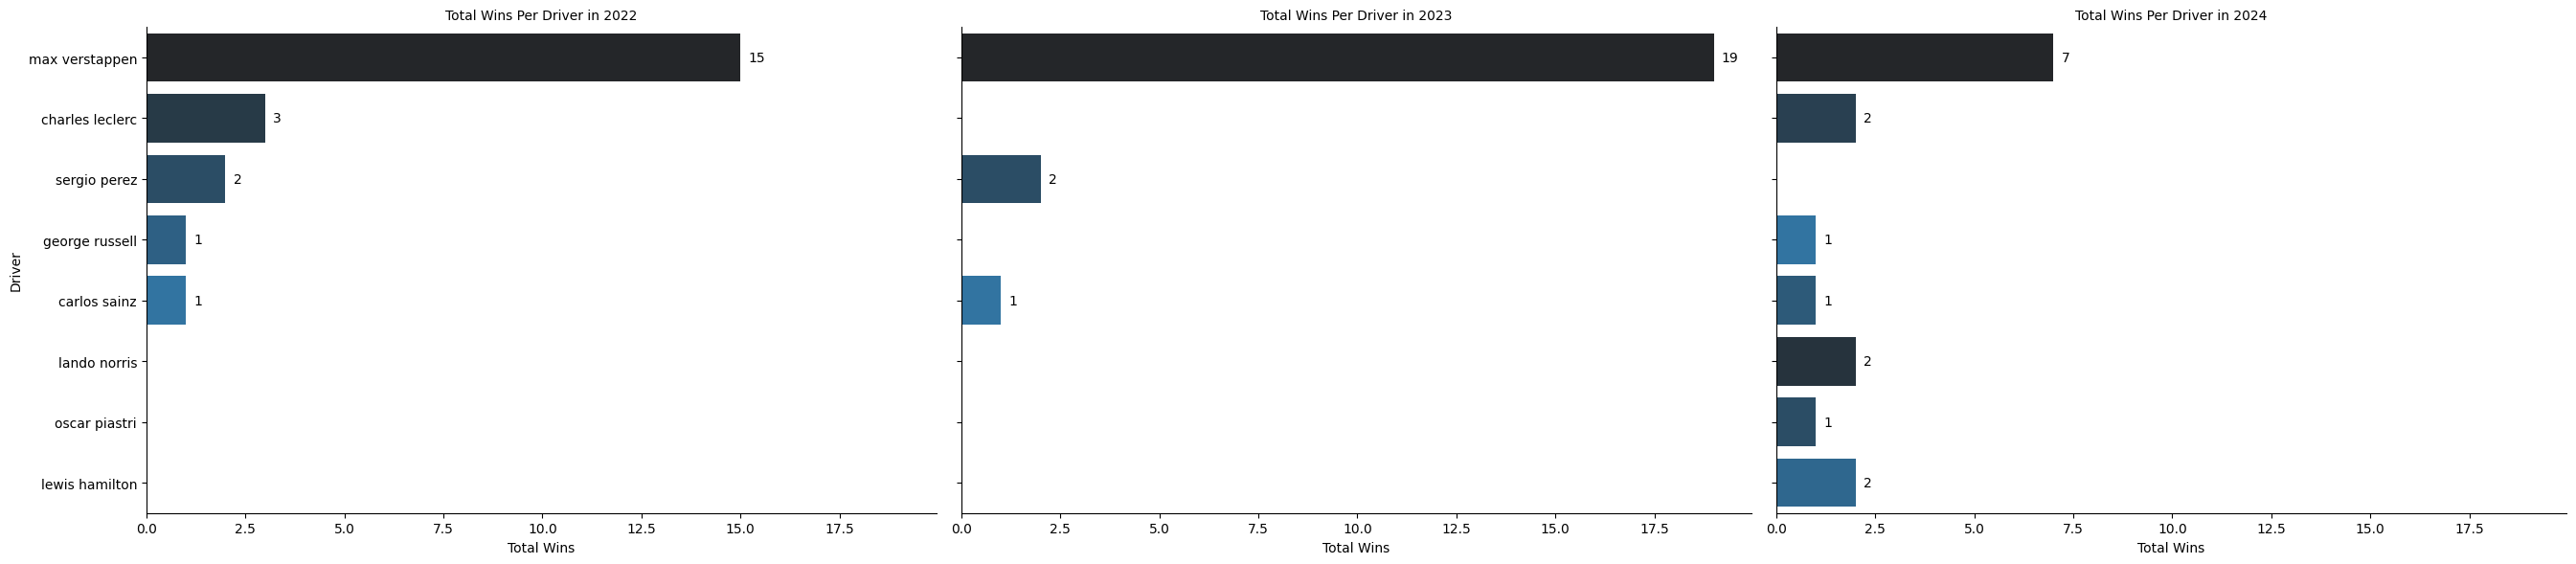

In [10]:
race_winners = wdc_2022_2024[wdc_2022_2024['Total Wins'] > 0]

# Set up a FacetGrid
g = sns.FacetGrid(race_podiums_per_team, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot,data = race_podiums_per_team, x = 'Total_Wins', y = 'Car', order=race_podiums_per_team['Car'].unique(), hue = 'Car', legend = False, palette = colour_palette, errorbar = None)

# Add labels to each bar in each facet
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width
        ax.text(width + 0.2,    # Position label slightly offset from the bar
                p.get_y() + p.get_height() / 2,  # Center label vertically on the bar
                f'{width:.0f}',   # The label text
                va='center')

# Adjust the titles and layout
g.set_titles("Total Wins Per Team in {col_name}")
g.set_axis_labels("Total Wins", "Driver")
plt.tight_layout()
plt.show()

# Set up a FacetGrid
g = sns.FacetGrid(race_winners, col='Year', col_wrap=3, height=6, aspect=1.5)

# Create a bar plot for total wins per driver in each year
g.map_dataframe(sns.barplot,data = race_winners, x = 'Total Wins', y = 'Driver', order=race_winners['Driver'].unique(), hue = 'Driver', legend = False,palette='dark:#1f77b4', errorbar = None)

# Add labels to each bar in each facet
for ax in g.axes.flat:
    for p in ax.patches:
        width = p.get_width()  # Get bar width
        ax.text(width + 0.2,    # Position label slightly offset from the bar
                p.get_y() + p.get_height() / 2,  # Center label vertically on the bar
                f'{width:.0f}',   # The label text
                va='center')

# Adjust the titles and layout
g.set_titles("Total Wins Per Driver in {col_name}")
g.set_axis_labels("Total Wins", "Driver")
plt.tight_layout()
plt.show()

Now we can see just how dominant Red Bull, and particularly Max Verstappen, were in 2022 and 2023. To add a little more context Max Verstappen now holds the record for the most races won in a year and also the 2nd most races won in a year with a win percentage of 68.2% and 86.2%. It is also just as impressive at how the other teams quickly caught up this year. The last time 4 different teams won a race was 2021 however you would have to go back all the way to 2012 to see 7 different drivers winning a race in a single year.

The graph below depicts how many points the top 4 teams accumulated per year. It pretty much shows what we already know; Red Bull running away with it in 2022 and especially 2023 leaving Mercedes and Ferrari to fight for the scraps. However what you can see is McLarens resurgence during 2023. I have annotated the graph to highlight any key upgrades McLaren brought to races.

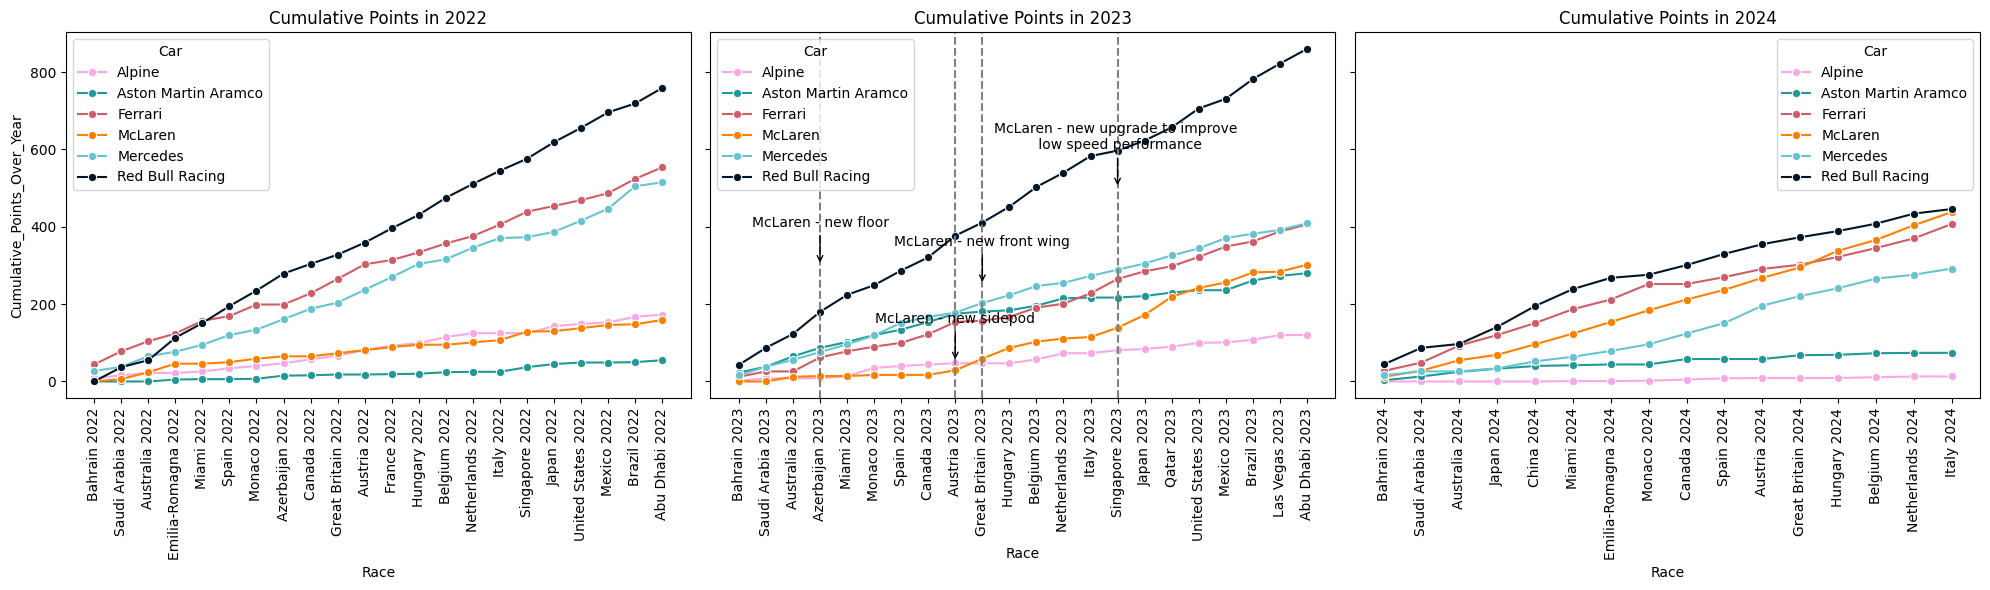

In [11]:
key_races = ['Azerbaijan 2023', 'Austria 2023', 'Great Britain 2023', 'Singapore 2023']
events = ['McLaren - new floor', 'McLaren - new sidepod','McLaren - new front wing', 'McLaren - new upgrade to improve \n low speed performance']

y_positions = [300, 50, 250, 500]  # Custom Y positions for each event
rotations = [0, 0, 0, 0, 0]  # Custom rotation angles for each annotation

race_results['Race'] = race_results['Circuit'] + ' ' + race_results['Year'].astype(str)
mclaren = race_results[race_results['Car'].isin(race_podiums_per_team['Car'])]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)  # 1 row, 3 columns, sharing the y-axis

# Define years you want to plot
years = [2022, 2023, 2024]

# Loop through each year and create separate line plots
for i, year in enumerate(years):
    # Filter data for the current year
    year_data = mclaren[mclaren['Year'] == year]
    
    # Create the line plot for the current year
    sns.lineplot(data=year_data, x='Race', y='Cumulative_Points_Over_Year', hue='Car', palette = colour_palette, marker='o', ax=axes[i])
    
    # Set the title for the subplot
    axes[i].set_title(f'Cumulative Points in {year}')
    
    # Rotate x-ticks for better readability
    axes[i].tick_params(axis='x', rotation=90)

    if year == 2023:
        for race, event,y_pos in zip(key_races, events,y_positions):
            axes[i].axvline(x=race, color='grey', linestyle='--', ymin=0, ymax=1)  # Add vertical line
            axes[i].annotate(event, xy=(race, y_pos), xytext=(race, y_pos + 100),  # Adjust y position as needed
                             arrowprops=dict(facecolor='black', arrowstyle='->'),
                             horizontalalignment='center', rotation=0)  # Customize rotation

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Overall 2023 was a very good year for McLaren because they replaced an aging Daniel Ricciardo with the up and coming Oscar Piastri which they'd hope would cement their driver line up for a good few years. They also recognised that the direction they were going with their car was wrong and decided to start from the beginning again starting with the new floor introduced at Azerbaijain. Although it didn't result in any immediate gains, it did allow them to have a solid foundation when it came to bringing new upgrades later on in the reason. The gamble evidently paid off because as of Austria 2023 they were consistently in the battle for a podium spot. But Mercedes consistency is what secured 2nd spot in the Constructors standings in 2023.

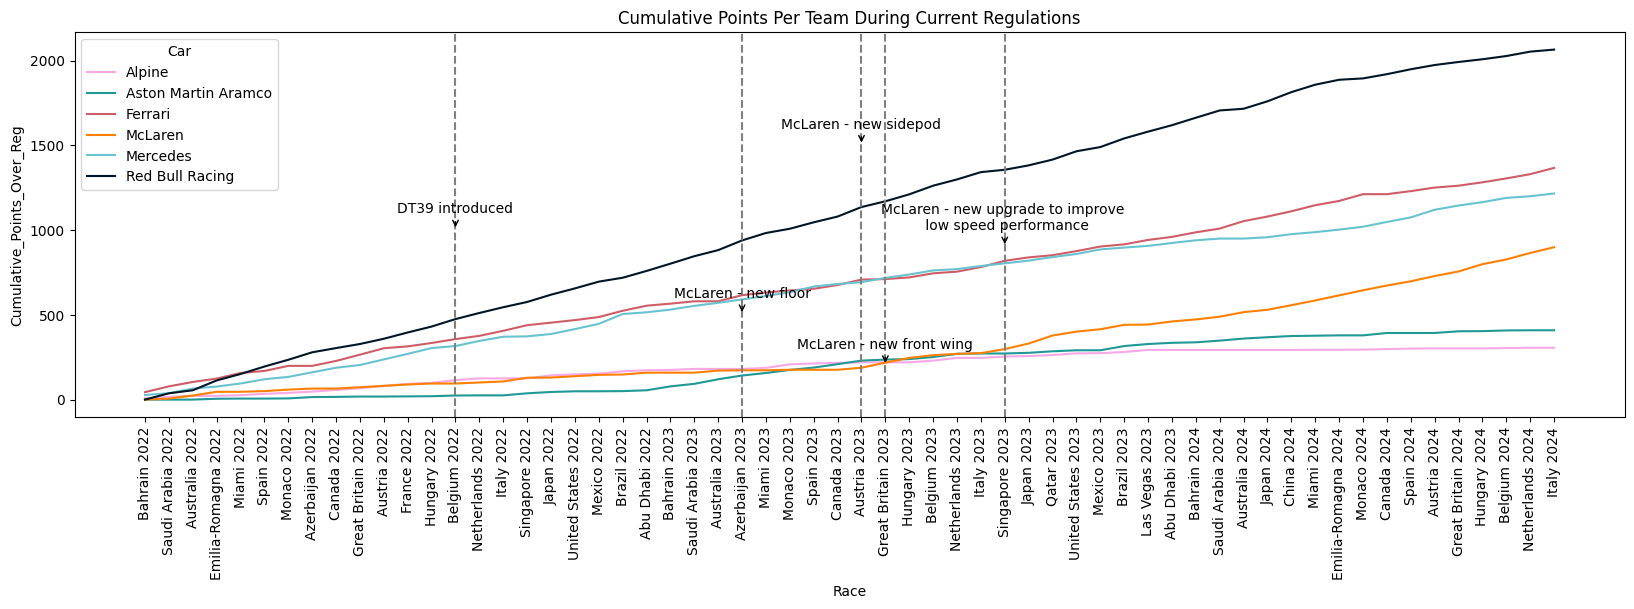

In [12]:
key_races = ['Belgium 2022','Azerbaijan 2023', 'Austria 2023', 'Great Britain 2023', 'Singapore 2023']
events = ['DT39 introduced', 'McLaren - new floor', 'McLaren - new sidepod','McLaren - new front wing', 'McLaren - new upgrade to improve \n low speed performance']

y_positions = [1000, 500, 1500, 200, 900]  # Custom Y positions for each event
rotations = [0, 0, 0, 0, 0]  # Custom rotation angles for each annotation

plt.figure(figsize= (20, 5))

sns.lineplot(data = mclaren,x = 'Race', y = 'Cumulative_Points_Over_Reg',hue = 'Car', palette = colour_palette)

for race, event, y_pos, rotation in zip(key_races, events, y_positions, rotations):
    plt.axvline(x=race, color='grey', linestyle='--', ymin=0, ymax=1)  # Add vertical line
    plt.annotate(event, xy=(race, y_pos), xytext=(race, y_pos + 100),  # Adjust y position
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 horizontalalignment='center', rotation=rotation)  # Customize rotation

plt.title('Cumulative Points Per Team During Current Regulations')

plt.xticks(rotation = 90)

plt.show()

This graph is similar to the previous graph however it shouls the points accumulated over the entire regulation period. It clearly shows what has already been discovered: Red Bull dominating the current regulation set, McLaren's comeback which started in Austria 2023 and both Ferrari and Mercedes battling each other.

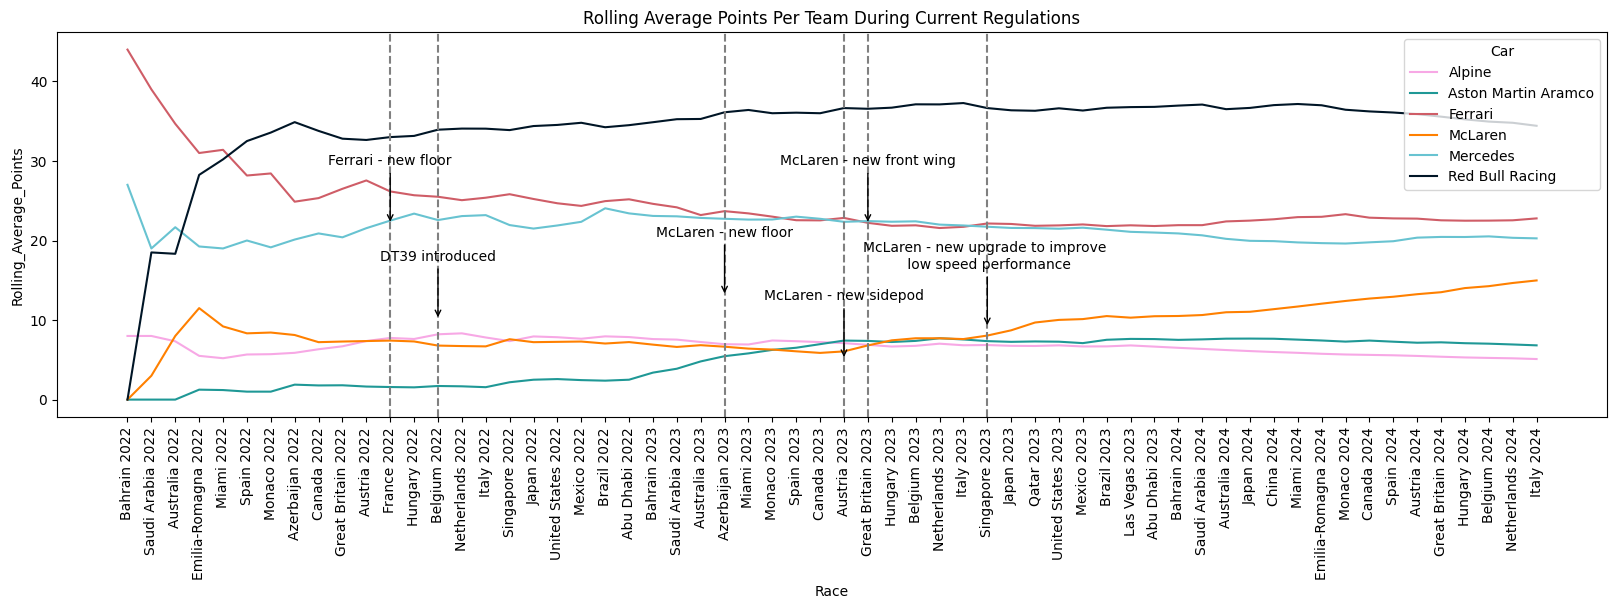

In [13]:
key_races = ['France 2022', 'Belgium 2022', 'Azerbaijan 2023', 'Austria 2023', 'Great Britain 2023', 'Singapore 2023']
events = ['Ferrari - new floor', 'DT39 introduced', 'McLaren - new floor', 'McLaren - new sidepod','McLaren - new front wing', 'McLaren - new upgrade to improve \n low speed performance']

y_positions = [22, 10, 13, 5, 22, 9]  # Custom Y positions for each event
rotations = [0, 0, 0, 0, 0, 0]  # Custom rotation angles for each annotation

plt.figure(figsize= (20, 5))

sns.lineplot(data = mclaren,x = 'Race', y = 'Rolling_Average_Points',hue = 'Car', palette = colour_palette)

for race, event, y_pos, rotation in zip(key_races, events, y_positions, rotations):
    plt.axvline(x=race, color='grey', linestyle='--', ymin=0, ymax=1)  # Add vertical line
    plt.annotate(event, xy=(race, y_pos), xytext=(race, y_pos + 7.5),  # Adjust y position
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 horizontalalignment='center', rotation=rotation)  # Customize rotation

plt.title('Rolling Average Points Per Team During Current Regulations')

plt.xticks(rotation = 90)

plt.show()

This graph shows the average points accumulated per team over the regulation period. 2022 was an interesting year because although it isn't reflected here Ferrari were relatively close to Red Bull however at Belgium 2022 a new technical directive was issued by the regulators (FIA). The aim of this was to address the porposing which refers to when the car is bouncing up and down due to how the ground effect worked with the 2022 cars. Although this isn't solely to blame for Ferrari's step back it is thought to be one of the contributing factors of it, along with the floor they introduced in France.

Again it highlights McLarens resurgence as of Austria 2023. Although it does help to have a strong driver pairing but the contributing factor to a teams success is the car and it is evident just how important it was that they got 2023 right in terms of the change in philosophy. It just as easily could have gone wrong for them as well. Although they didn't start the current regulation period as they hoped for, they are shaping up to end it on a high note potentially winning the Constructors championship this year and potentially challenging for the Drivers championship as well.